In [188]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import mne
import yasa

In [189]:
# Loading the PSG file
psg_file = "data/SC4001E0-PSG.edf"

# Creating a raw 'mne' object
raw = mne.io.read_raw_edf(psg_file, preload = True, verbose='error') 

print("\n")
print("Below are the channel names of the main file we uploaded:")
print("\n")
print(raw.info["ch_names"])

# We will work on EEG only
raw.pick_channels(['EEG Fpz-Cz', 'EEG Pz-Oz'])
# Note: the same result will come from the line:
# raw.drop_channels(["EOG horizontal", "Resp oro-nasal", "EMG submental", "Temp rectal", "Event marker"])

# The below is optional. Interesting to check if accuracy is better with/without the filter.
raw.filter(0.3, 30)

# Loading the Hypnogram file. This contains the annotations (labels) assigned from sleep experts
hypnogram_file = "data/SC4001EC-Hypnogram.edf"

# We extract the annotations
annotations = mne.read_annotations(hypnogram_file)

# We 'align' the annotations in our raw mne object
raw.set_annotations(annotations)



Below are the channel names of the main file we uploaded:


['EEG Fpz-Cz', 'EEG Pz-Oz', 'EOG horizontal', 'Resp oro-nasal', 'EMG submental', 'Temp rectal', 'Event marker']
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.3 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.30
- Lower transition bandwidth: 0.30 Hz (-6 dB cutoff frequency: 0.15 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 1101 samples (11.010 s)



C:\Users\camen\AppData\Local\Temp\ipykernel_10600\745021208.py:27: RuntimeWarning: Limited 1 annotation(s) that were expanding outside the data range.
  raw.set_annotations(annotations)


<RawEDF | SC4001E0-PSG.edf, 2 x 7950000 (79500.0 s), ~121.3 MiB, data loaded>

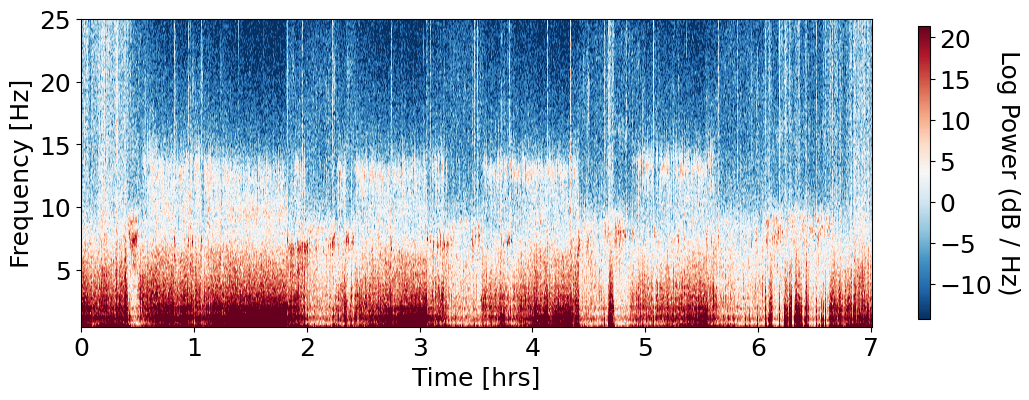

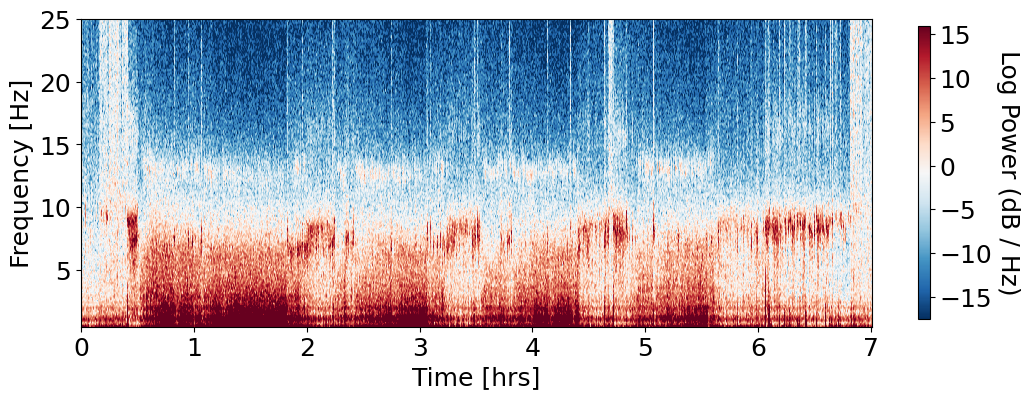

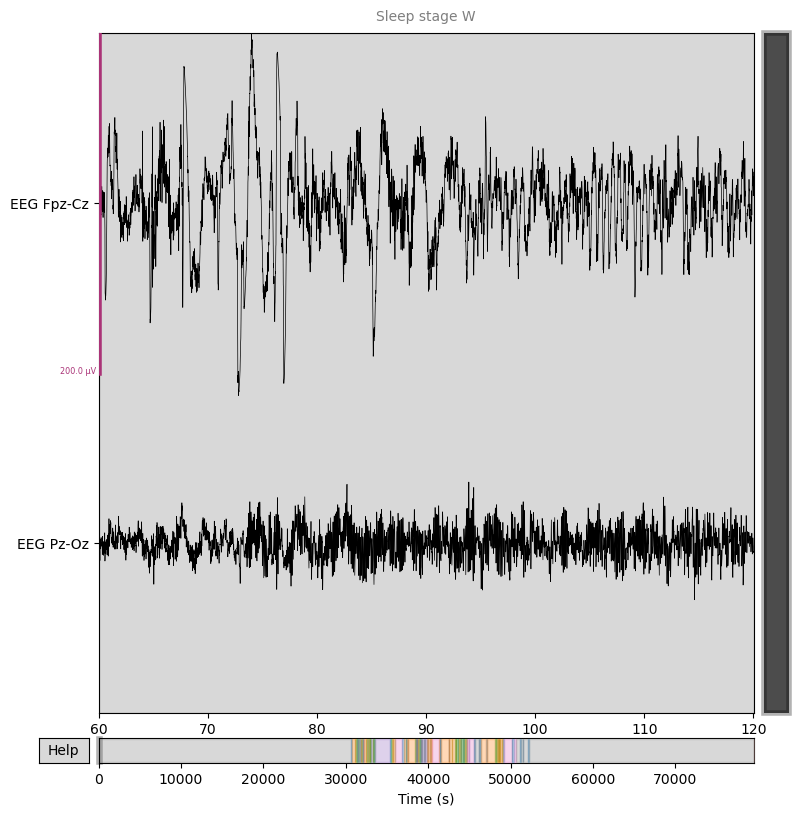

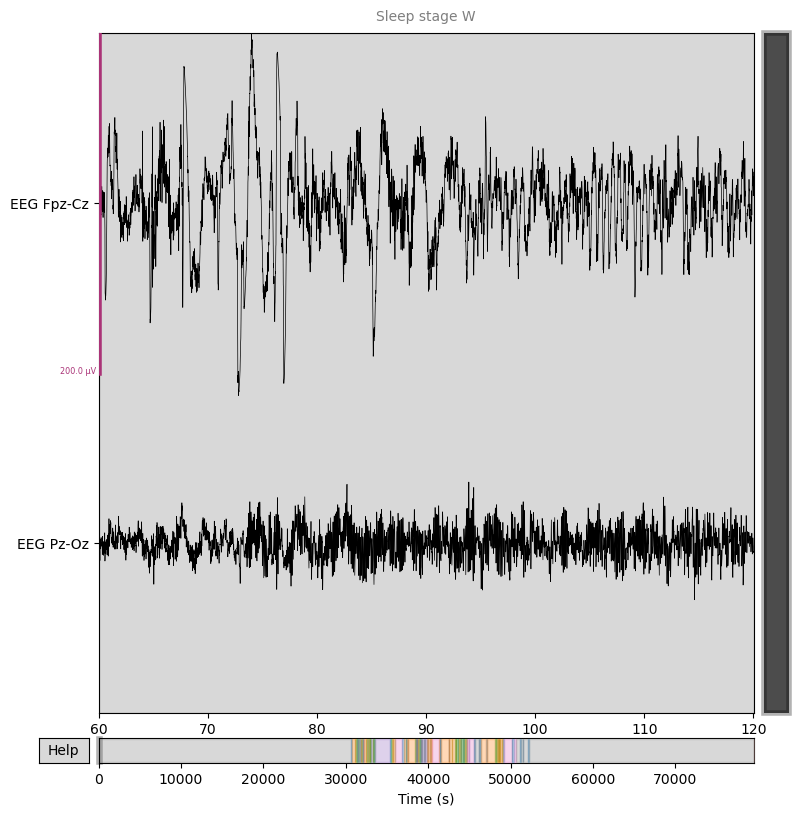

In [190]:
# We plot the data to get a feel of what we ve got
raw.plot(start=60,
    duration=60,
    scalings=dict(eeg=1e-4, resp=1e3, eog=1e-4, emg=1e-7, misc=1e-1))

In [191]:
print(raw.annotations)

<Annotations | 154 segments: Sleep stage 1 (24), Sleep stage 2 (40), Sleep ...>


In [192]:
annotation_description_to_event_id = {
    "Sleep stage W": 0,
    "Sleep stage 1": 1,
    "Sleep stage 2": 2,
    "Sleep stage 3": 3,
    "Sleep stage 4": 3,
    "Sleep stage R": 4,
}

annotations.crop(annotations[1]['onset'] - 30*60, annotations[-2]['onset'] + 30*60)
raw.set_annotations(annotations)

events, _ = mne.events_from_annotations(raw, event_id = annotation_description_to_event_id, 
                                       chunk_duration=30.0)
event_id = {
    "Sleep stage W": 0,
    "Sleep stage 1": 1,
    "Sleep stage 2": 2,
    "Sleep stage 3/4": 3,
    "Sleep stage R": 4,
}



Used Annotations descriptions: [np.str_('Sleep stage 1'), np.str_('Sleep stage 2'), np.str_('Sleep stage 3'), np.str_('Sleep stage 4'), np.str_('Sleep stage R'), np.str_('Sleep stage W')]


In [193]:
tstart = annotations.onset[0]
tend = annotations.onset[-1]  + 30.0*60

In [194]:
raw_cropped = raw.copy().crop(tmin=tstart, tmax=tend, include_tmax=True)

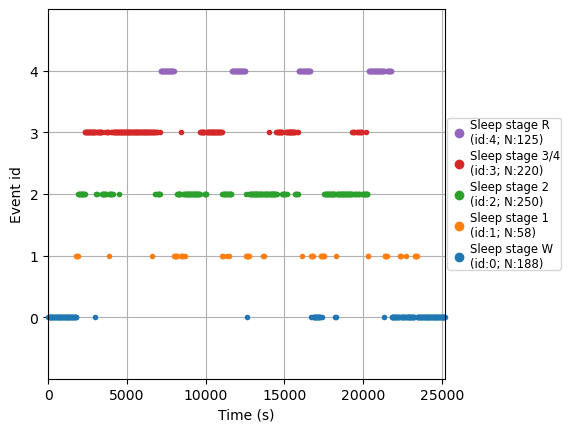

In [195]:
fig = mne.viz.plot_events(
    events,
    event_id=event_id,
    sfreq=raw.info["sfreq"],
    first_samp=events[0, 0],
)
# keeping the color-code for further plotting
stage_colors = plt.rcParams["axes.prop_cycle"].by_key()["color"]

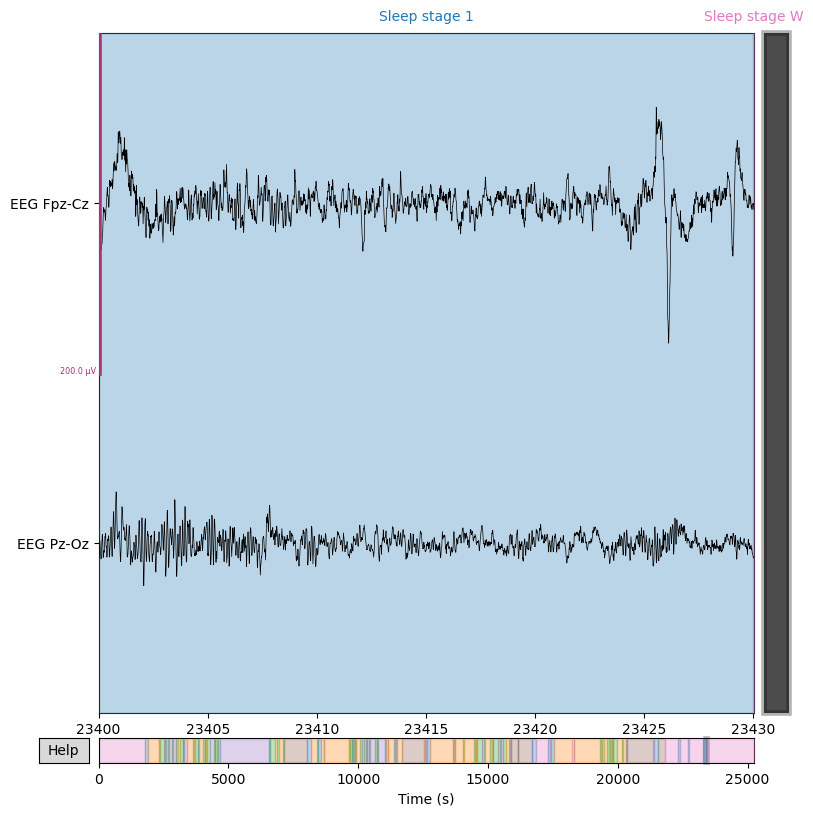

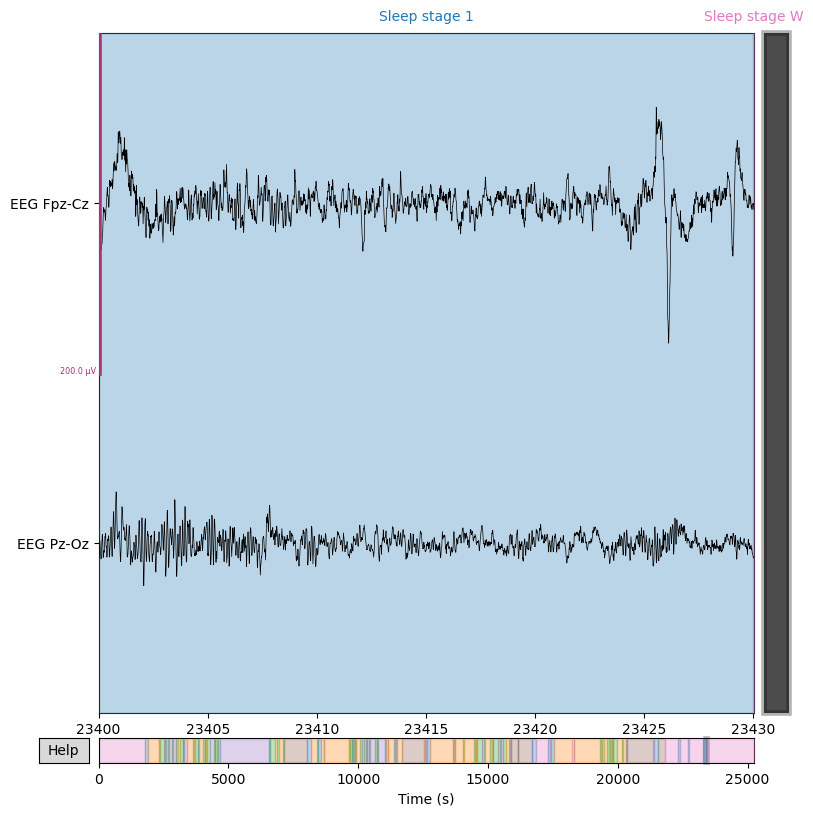

In [196]:
# We plot the data to get a feel of what we ve got
raw_cropped.plot(start=23400,
    duration=30,
    scalings=dict(eeg=1e-4, resp=1e3, eog=1e-4, emg=1e-7, misc=1e-1))

In [197]:
print(raw.annotations)
print(raw_cropped.annotations)

<Annotations | 153 segments: Sleep stage 1 (24), Sleep stage 2 (40), Sleep ...>
<Annotations | 153 segments: Sleep stage 1 (24), Sleep stage 2 (40), Sleep ...>


In [198]:
epoch_length = 30.0 #seconds

epochs = mne.Epochs(raw_cropped,
                   events,
                   event_id=event_id,
                   tmin=0,
                   tmax=epoch_length-1/sfreq,
                   baseline=None,
                   preload=True
                   )


Not setting metadata
841 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 841 events and 3000 original time points ...
0 bad epochs dropped


In [199]:
labels = epochs.events[:, 2]
label_names = [k for k,v in event_id.items() if v in labels]

labels.size

841

In [200]:
# Don't know why I wrote these. I'll keep them here.
stage_map = {v: k for k, v in event_id.items()}
stage_labels = [stage_map[label] for label in labels]

stage_map

{0: 'Sleep stage W',
 1: 'Sleep stage 1',
 2: 'Sleep stage 2',
 3: 'Sleep stage 3/4',
 4: 'Sleep stage R'}

In [201]:
data_1 = epochs.get_data(units= "uV")

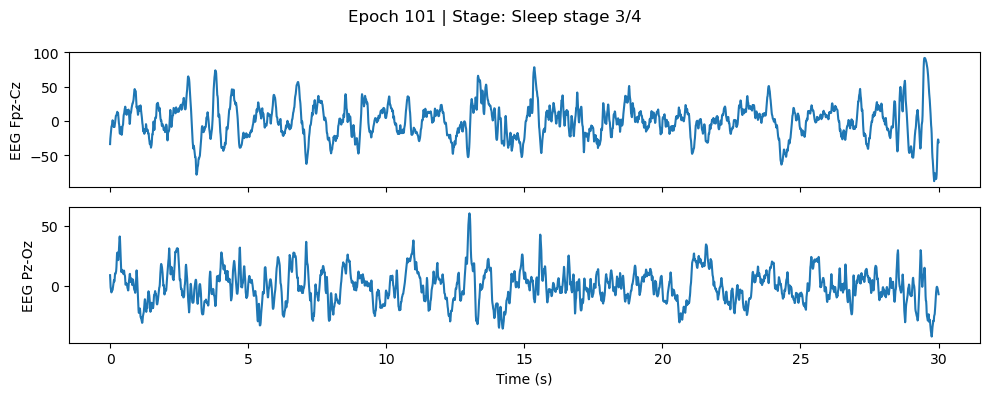

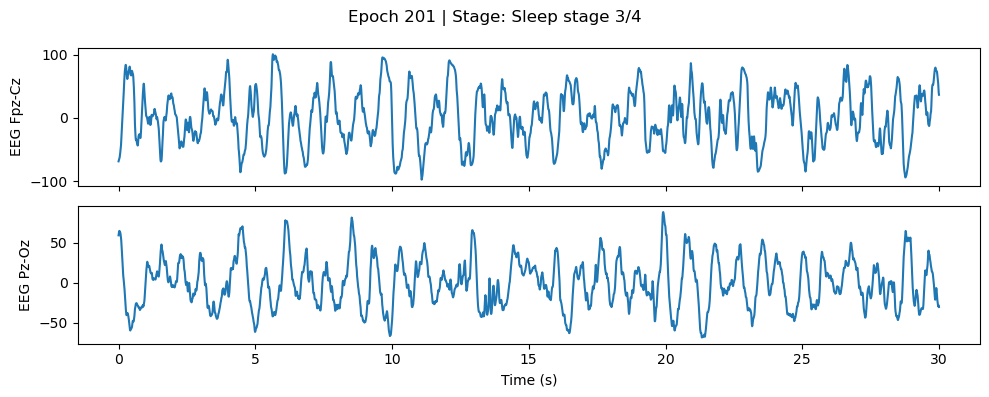

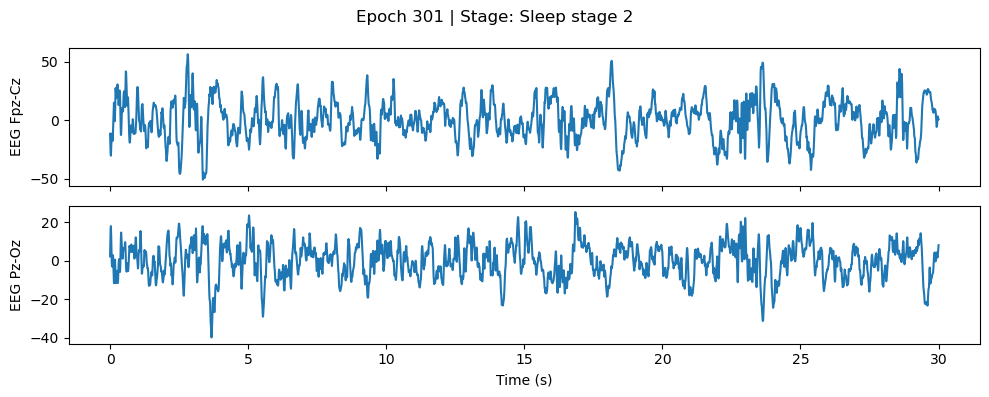

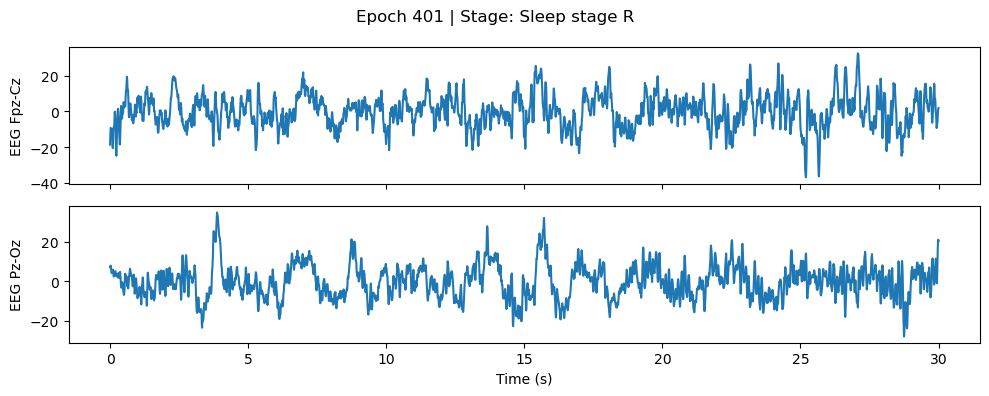

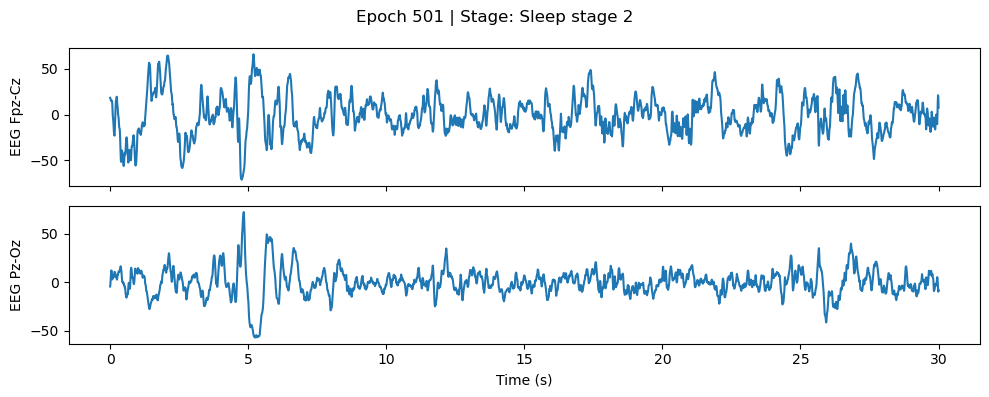

In [202]:
sf =int(epochs.info['sfreq'])

for i in [100,200,300,400,500]:
    fig, axs = plt.subplots(2,1, figsize=(10,4), sharex=True)
    time = np.linspace(0,30, data_1.shape[2])
    for ch in range(2):
        axs[ch].plot(time, data_1[i, ch])
        axs[ch].set_ylabel(epochs.ch_names[ch])
    axs[-1].set_xlabel("Time (s)")
    plt.suptitle(f"Epoch {i+1} | Stage: {stage_labels[i]}")
    plt.tight_layout()
    plt.show()
    

In [203]:
data = raw.get_data(units = "uV")
print(data.shape)
data_cropped = raw_cropped.get_data(units = 'uV')
print(data_cropped.shape)

(2, 7950000)
(2, 2523001)


In [206]:
sf

100

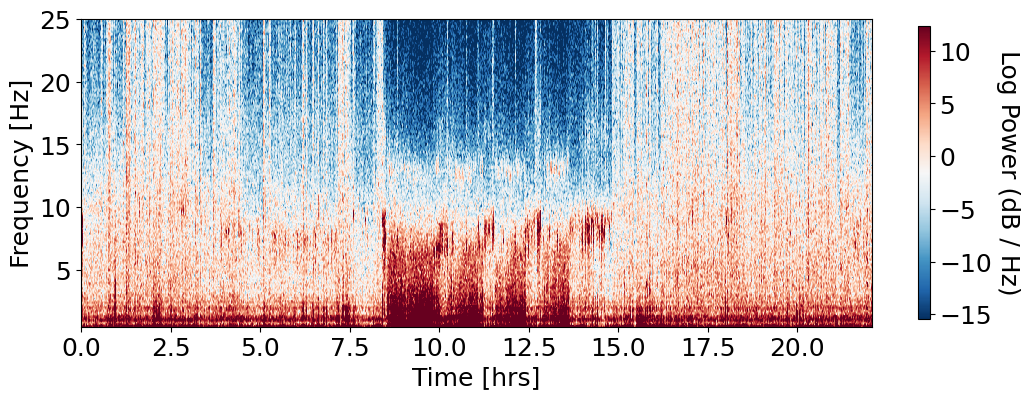

In [209]:
yasa.plot_spectrogram(data[1], sf)

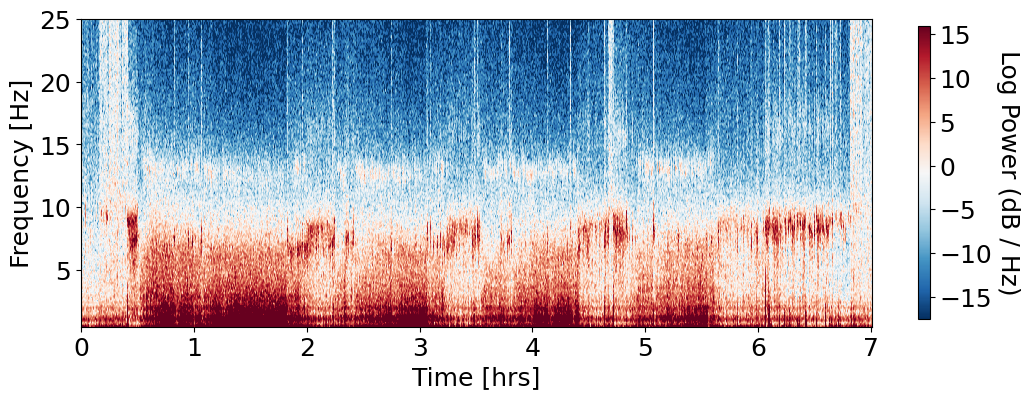

In [207]:
yasa.plot_spectrogram(data_cropped[1], sf)